In [2]:
import torch
from torch import nn
import rdkit
from tqdm import tqdm
from rdkit import Chem
import pandas as pd
from importlib import reload
import matplotlib.pyplot as plt
from rdkit import RDLogger

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')

In [3]:
import sascorer

In [4]:
torch.set_default_device('cuda')

In [5]:
from constants import *

In [6]:
import  generator as G
import discriminator as D
import rewardnet as R
import mlp as M
import rgcn
from molecularmetrics import MolecularMetrics

In [7]:
zinc250k=pd.read_csv("250k_rndm_zinc_drugs_clean.csv")
sampled=zinc250k.sample(1000).reset_index(drop=True)

In [8]:
zinc250k.head(5)

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


In [9]:
logp_scale=zinc250k['logP'].quantile([0.05,0.95]).values
qed_scale=zinc250k['qed'].quantile([0.05,0.95]).values
sas_scale=zinc250k['SAS'].quantile([0.05,0.95]).values

# Atom count (with atomic numbers)
![atom_count](atom_counts.png "Atom Count")

In [10]:
def graph_from_smiles(smiles,return_mol=False):
    rdkit_mol=Chem.MolFromSmiles(smiles)
    X=[list(MOLS.keys()).index(i.GetAtomicNum()) for i in rdkit_mol.GetAtoms()]
    N=len(X)
    A=torch.zeros(N,N)
    for i in range(N):
        for j in range(N):
            try:
                A[i,j]=BONDS[rdkit_mol.GetBondBetweenAtoms(i,j).GetBondType()]
            except:
                pass
    X=nn.functional.one_hot(torch.tensor(X), num_classes=len(MOLS))
    A=nn.functional.one_hot(A.to(int), num_classes=len(BONDS)).permute(-1,0,1)
    if return_mol: 
        return X,A,rdkit_mol
    return X,A

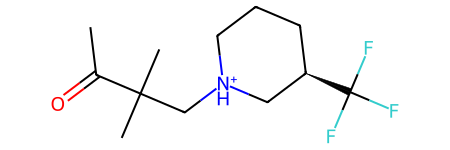

In [11]:
smiles_sample=sampled['smiles'][0]
x,a=graph_from_smiles(smiles_sample)
x=x.to(torch.float32).unsqueeze(0)
a=a.to(torch.float32).unsqueeze(0)
mol0=Chem.MolFromSmiles(smiles_sample)
mol0

In [27]:
r1=rgcn.RGCN(len(MOLS),[5,6,7],1)
r1o=torch.optim.AdamW(r1.parameters(),lr=1e-3)
it=tqdm(range(400))
losses=[]
for i in it:
    s=zinc250k.sample(1).iloc[0]
    smiles_sample=s['smiles']
    x,a=graph_from_smiles(smiles_sample)
    x=x.to(torch.float32).unsqueeze(0)
    a=a.to(torch.float32).unsqueeze(0)

    out,_=r1((x,a))
    out=out.sum()
    loss=(out-s['qed'])**2
    l=float(loss.detach().cpu().numpy())
    losses.append(l)
    if i==299: continue
    it.set_description(f'{l*1000:.2f}')
    r1.zero_grad(set_to_none=True)
    loss.backward()
    r1o.step()


32.95: 100%|██████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:06<00:00, 58.98it/s]


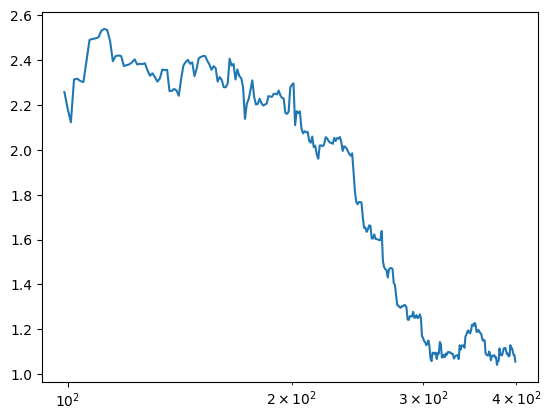

In [28]:
ax=pd.Series(losses).rolling(window=100).mean().plot()
ax.set_xscale('log')

In [29]:
def mol_from_graph(x,a,strict=True):
    assert a.shape[-3]==len(BONDS), "a: [N_BONDS, N_ATOMS, N_ATOMS]"
    assert len(a.shape)==3 or (len(a.shape)==4 and a.shape[0]==1), "batched operation not supported"
    if len(a.shape)==4:
        a=a[0]
        x=x[0]
    X_map=[*MOLS.keys()]
    iBOND = {BONDS[k]:k for k in BONDS}
    mol = Chem.RWMol()
    bonds=frozenset([])
    for node_label in x:
        mol.AddAtom(Chem.Atom(X_map[node_label.argmax().detach().cpu().numpy()]))

    for t,r,c in a[1:,:,:].argwhere().detach().cpu().numpy().tolist():
        if frozenset([r,c]) in bonds: continue
        if r==c: continue
        mol.AddBond(r, c, iBOND[t+1])#t+1 because t=0 now maps to SINGLEBOND because of a[1:,:,:]
        bonds |= frozenset([frozenset([r,c])])
        
    if strict:
        try:
            Chem.SanitizeMol(mol)
        except:
            mol = None

    return mol

In [30]:
def sample_gumbel(x,a,temperature=1.0,hard=False,method=None):
    x = nn.functional.gumbel_softmax(x,tau=temperature,hard=hard,dim=-1)
    a = nn.functional.gumbel_softmax(a,tau=temperature,hard=hard,dim=-3)
    return (x,a)

In [31]:
def reward(mol):
    rr=1
    for m in ('logp','sas','qed'):
        if m == 'logp':
            rr *= MolecularMetrics.water_octanol_partition_coefficient_scores([mol], norm=True)
        elif m == 'sas':
            rr *= MolecularMetrics.synthetic_accessibility_score_scores([mol], norm=True)
        elif m == 'qed':
            rr *= MolecularMetrics.quantitative_estimation_druglikeness_scores([mol], norm=True)
    return rr[0]

In [97]:
def gradient_penalty(y, x):
    """Compute gradient penalty: (L2_norm(dy/dx) - 1)**2."""
    weight = torch.ones(y.size())
    dydx = torch.autograd.grad(outputs=y,
                               inputs=x,
                               grad_outputs=weight,
                               retain_graph=True,
                               create_graph=True,
                               only_inputs=True)[0]
    print('dydx',dydx.sum().detach().item())
    dydx = dydx.view(dydx.size(0), -1)
    dydx_l2norm = torch.sqrt(torch.sum(dydx ** 2, dim=1))
    res = torch.mean((dydx_l2norm - 1) ** 2)
    print('res',res.detach().item())
    return res

In [98]:
class Solver:
    def __init__(self, G, D, R, z_dim, lr=1e-3, lambda_wgan=WGAN_BIAS_LAMBDA, lambda_gp=GP_LAMBDA, loss_ema_n=200):
        self.G=G
        self.D=D
        self.R=R
        self.G_opt=torch.optim.AdamW(self.G.parameters(),lr=lr)
        self.D_opt=torch.optim.AdamW(self.D.parameters(),lr=lr)
        self.R_opt=torch.optim.AdamW(self.R.parameters(),lr=lr)
        self.z_dim=z_dim
        self.lambda_wgan=lambda_wgan
        self.lambda_gp=lambda_gp
        self.loss_ema_n=loss_ema_n
    def train(self, dataset, ema_n=200, max_iters=-1):
        graphs = [graph_from_smiles(s,return_mol=True) for s in tqdm(dataset['smiles'][:max_iters],desc='converting graph from smiles...')]
        #iterator = tqdm(graphs, desc='training', total=max_iters if max_iters>=0 else None)
        loss_ema=0
        for real_x,real_a,real_mol in graphs:#iterator:
            if max_iters==0: break
            max_iters-=1
            z=sample(self.z_dim)
            real_x=real_x.to(torch.float32).unsqueeze(0)
            real_a=real_a.to(torch.float32).unsqueeze(0)
            
            # =======================
            #   train discriminator
            # =======================
            print("=== train discriminator")

            # TODO: graph reward
            
            D_x = self.D((real_x,real_a))
            #print("D_x",D_x)
            (fake_x, fake_a) = self.G(z)
            fake_x = fake_x.detach()#detach because we dont want to nudge generator parameter in this part
            fake_a = fake_a.detach()
            print('fake.sum()',fake_x.sum().item(), fake_a.sum().item())
            (sampled_fake_x, sampled_fake_a) = sample_gumbel(fake_x, fake_a)
            D_G_z = self.D((sampled_fake_x, sampled_fake_a))
            print("D_G_z",D_G_z.detach().item(),sampled_fake_x.sum().detach().item(), sampled_fake_a.sum().detach().item())
            eps = torch.rand([])
            fake_n=sampled_fake_a.shape[-1]
            real_n=real_a.shape[-1]
            if real_n>fake_n:
                fake_a_tmp = torch.zeros_like(real_a)
                fake_a_tmp[...,:,:fake_n,:fake_n]=fake_a
                fake_x_tmp = torch.rand_like(real_x)/1e9
                fake_x_tmp[...,:fake_x.shape[-2],:]=fake_x
                sampled_fake_a=fake_a_tmp
                sampled_fake_x=fake_x_tmp
            elif real_n!=fake_n:
                real_a_tmp = torch.zeros_like(sampled_fake_a)
                real_a_tmp[...,:,:real_n,:real_n]=real_a
                real_x_tmp = torch.rand_like(sampled_fake_x)/1e9
                real_x_tmp[...,:real_x.shape[-2],:]=real_x
                real_a=real_a_tmp
                real_x=real_x_tmp
            #print('real',real_x.shape,real_a.shape)
            #print('sampled_fake',sampled_fake_x.shape,sampled_fake_a.shape)
            (x_hat_x, x_hat_a) = ( #x_hat = e*fake+(1-e)*real where e~U(0,1)
                (eps*sampled_fake_x + (1-eps)*real_x).detach().requires_grad_(True),# 
                (eps*sampled_fake_a + (1-eps)*real_a).detach().requires_grad_(True),# 
            )
            D_x_hat = self.D((x_hat_x, x_hat_a))
            gp_loss = self.lambda_gp*(gradient_penalty(D_x_hat,x_hat_x))#+gradient_penalty(D_x_hat,x_hat_a))
            loss_D = D_G_z-D_x+gp_loss #GRADIENT PENALTY LOSS IS MAIN CULPRIT FOR NAN
            #if it errors because loss_D is not a scalar, then gp_loss calculations needs a .mean()
            #although, it shouldn't happen when batching has not been implemented
            self.D.zero_grad(set_to_none=True)
            loss_D.backward()
            self.D_opt.step()
            
            # ===================
            #   train rewardnet
            # ===================
            print("=== train rewardnet")

            real_reward = reward(real_mol)
            fake_reward = reward(mol_from_graph(sampled_fake_x, sampled_fake_a))

            R_x = self.R((real_x, real_a))
            R_G_z = self.R((sampled_fake_x, sampled_fake_a))
            
            loss_V = (R_x - real_reward).abs()# + (R_G_z - fake_reward).abs() <- I'm half afraid that this part will induce too much noice. Isn't |R(x)-reward(x)| enough?
            
            self.R.zero_grad(set_to_none=True)
            loss_V.backward()
            self.R_opt.step()
            
            # ===================
            #   train generator
            # =================== 
            print("=== train generator")

            z=sample(self.z_dim)
            (fake_x, fake_a) = self.G(z)
            print('fake.sum()',fake_x.sum().detach().item(), fake_a.sum().detach().item())
            (sampled_fake_x, sampled_fake_a) = sample_gumbel(fake_x, fake_a)
            D_G_z = self.D((sampled_fake_x, sampled_fake_a))
            print("D_G_z",D_G_z.detach().item(),sampled_fake_x.sum().detach().item(), sampled_fake_a.sum().detach().item())
            #print(fake_x.sum(),sampled_fake_x.sum())
            loss_G_wgan = -D_G_z

            real_reward = reward(real_mol)
            fake_reward = reward(mol_from_graph(sampled_fake_x, sampled_fake_a))

            R_x = self.R((real_x, real_a))
            R_G_z = self.R((sampled_fake_x, sampled_fake_a))
            
            loss_RL = -R_G_z

            alpha = torch.abs(loss_G_wgan.detach() / (loss_RL.detach()+1e-9)).detach()
            loss_molgan = self.lambda_wgan * loss_G_wgan + (1 - self.lambda_wgan) * alpha * loss_RL
            la,lb,lc,ld,le=(loss_molgan.detach().cpu(), loss_V.detach().cpu(), loss_D.detach().cpu(), loss_G_wgan.detach().cpu(), loss_RL.detach().cpu())
            la=float(la)
            lb=float(lb)
            lc=float(lc)
            ld=float(ld)
            le=float(le)
            loss_sum = float(loss_molgan.detach().cpu()+loss_V.detach().cpu()+loss_D.detach().cpu())
            
            loss_ema = (1-1/ema_n)*loss_ema + loss_sum/ema_n
            self.G.zero_grad(set_to_none=True)
            loss_molgan.backward()
            self.G_opt.step()
            print(f"loss:{loss_ema:.2f} loss_molgan:{la:.2f} loss_V:{lb:.2f} loss_D:{lc:.2f} loss_G_wgan:{ld:.2f} loss_RL:{le:.2f}")

            #iterator.set_description(f"loss:{loss_ema:.2f} loss_molgan:{la:.2f} loss_V:{lb:.2f} loss_D:{lc:.2f} loss_G_wgan:{ld:.2f} loss_RL:{le:.2f}")

In [99]:
rgcn=reload(rgcn)
D=reload(D)
G=reload(G)
R=reload(R)

In [100]:
Z_DIM=32
g = G.Generator(Z_DIM, [128, 256, 512], [], [], 9)
#input_dim, rgcn_dims, i_dims, j_dims, final_mlp_dims
d = D.Discriminator([128, 64], [128], [128], [128, 4])
r = R.Rewarder([64, 32], [128,32], [128,32], [16,8])

#g = G.Generator(32, [128, 256, 512], [], [], 9)
##input_dim, rgcn_dims, i_dims, j_dims, final_mlp_dims
#d = D.Discriminator([128, 256, 128, 128, 64], [128, 64], [128, 64], [128, 64])
#r = R.Rewarder([128, 256, 128, 128, 64], [128, 64], [128, 64], [128, 64])

In [101]:
solver = Solver(g,d,r,Z_DIM)

In [102]:
solver.train(zinc250k,max_iters=100)

converting graph from smiles...: 100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 234.33it/s]


=== train discriminator
fake.sum() 9.0 81.0
D_G_z -0.0 9.0 80.99999237060547
dydx -0.7588395476341248
res 0.7187181711196899
=== train rewardnet
=== train generator
fake.sum() 9.0 81.0
D_G_z -0.4105493426322937 9.0 81.0
loss:0.04 loss_molgan:-0.40 loss_V:0.12 loss_D:7.41 loss_G_wgan:0.41 loss_RL:-0.42
=== train discriminator
fake.sum() 9.0 81.0
D_G_z -0.44509074091911316 9.0 81.0
dydx -0.3335210680961609
res 0.5905104875564575
=== train rewardnet
=== train generator
fake.sum() 9.0 81.0
D_G_z -0.42416203022003174 9.0 81.0
loss:0.06 loss_molgan:-0.42 loss_V:0.15 loss_D:5.42 loss_G_wgan:0.42 loss_RL:-0.42
=== train discriminator
fake.sum() 9.0 81.0
D_G_z -0.30283674597740173 9.0 81.0
dydx -0.42475903034210205
res 0.6657139658927917
=== train rewardnet
=== train generator
fake.sum() 9.0 81.0
D_G_z -0.3087661564350128 9.0 81.0
loss:0.09 loss_molgan:-0.30 loss_V:0.05 loss_D:6.03 loss_G_wgan:0.31 loss_RL:-0.42
=== train discriminator
fake.sum() 9.0 81.0
D_G_z -0.5819998979568481 9.0 81.0
dydx

WGAN-GP formula

$\underset{G}{\min}\underset{D}{\max}{[D(x)-D(G(z))+\lambda(\nabla_\hat{x}||D(\hat{x})||_2-1)^2]};x\sim X;z\sim p(z)$

In [171]:
def train_rewardnet(rewardnet, optimizer, dataset, max_iters=-1):
    logp_t=lambda x:(min(max(logp_scale[0],x),logp_scale[1])-logp_scale[0])/(logp_scale[1]-logp_scale[0])
    qed_t=lambda x:(min(max(qed_scale[0],x),qed_scale[1])-qed_scale[0])/(qed_scale[1]-qed_scale[0])
    sas_t=lambda x:(min(max(sas_scale[0],x),sas_scale[1])-sas_scale[0])/(sas_scale[1]-sas_scale[0])
    iterator=tqdm(range(dataset.shape[0]), total=max_iters if max_iters>=0 else None)
    loss_ema = 0
    ema_n = 200
    for i in iterator:
        if max_iters==0: break
        max_iters-=1
        mol_smiles=dataset.iloc[i]['smiles']
        (x,a)=graph_from_smiles(mol_smiles)
        x=x.to(torch.float32).unsqueeze(0)
        a=a.to(torch.float32).unsqueeze(0)
        reward = logp_t(dataset.iloc[i]['logP']) * qed_t(dataset.iloc[i]['qed']) * sas_t(dataset.iloc[i]['SAS'])
        (rout,_)=r((x,a))
        rout = rout[0][0]
        #print(rout)
        mse = (rout-reward).abs()
        loss_ema = loss_ema * (1-1/ema_n) + (1/ema_n) * mse.detach().cpu()
        rewardnet.zero_grad(set_to_none=True)
        mse.backward()
        optimizer.step()
        iterator.set_description(f"loss:{loss_ema:.3f}. rout: {rout:.2f}. reward: {reward:.2f}")

In [176]:
train_rewardnet(r, optimizer_r, zinc250k, max_iters=1_000)

loss:0.085. rout: 0.10. reward: 0.18: 100%|████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.12it/s]


In [178]:
def eval_rewardnet(rewardnet, dataset,max_guesses=2_000):
    with torch.no_grad():
        logp_t=lambda x:(min(max(logp_scale[0],x),logp_scale[1])-logp_scale[0])/(logp_scale[1]-logp_scale[0])
        qed_t=lambda x:(min(max(qed_scale[0],x),qed_scale[1])-qed_scale[0])/(qed_scale[1]-qed_scale[0])
        sas_t=lambda x:(min(max(sas_scale[0],x),sas_scale[1])-sas_scale[0])/(sas_scale[1]-sas_scale[0])
        
        iterator=tqdm(range(dataset.shape[0]),total=max_guesses)
        loss_ema = 0
        ema_n = 200
        guesses=[]
        for i in iterator:
            max_guesses-=1
            mol_smiles=dataset.iloc[i]['smiles']
            (x,a)=graph_from_smiles(mol_smiles)
            x=x.to(torch.float32).unsqueeze(0)
            a=a.to(torch.float32).unsqueeze(0)
            reward = logp_t(dataset.iloc[i]['logP']) * qed_t(dataset.iloc[i]['qed']) * sas_t(dataset.iloc[i]['SAS'])
            (rout,_)=r((x,a))
            rout = rout[0][0]
            #print(rout)
            guesses.append([float(rout.cpu()), reward])
            if max_guesses<=0: break
        return guesses

In [179]:
eval_out=eval_rewardnet(r, zinc250k)

100%|████████████████████████████████████████████████████████████████████████████▉| 1999/2000 [00:15<00:00, 131.82it/s]


0.08661126797047718


Text(0, 0.5, 'prediction with reward network')

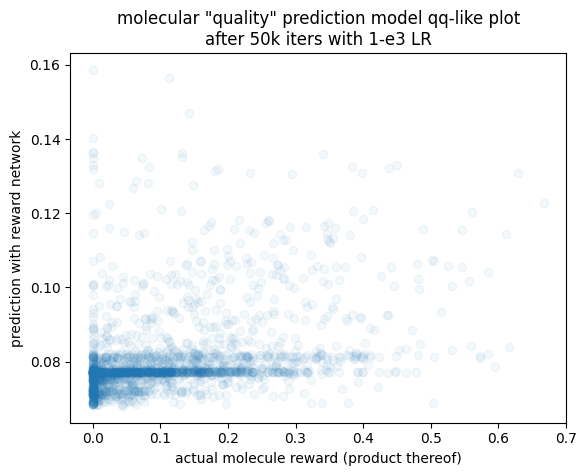

In [180]:
tmp=pd.DataFrame(eval_out)
print((tmp[0]-tmp[1]).abs().mean())
plt.scatter(tmp[1],tmp[0],alpha=0.05)
plt.title('molecular "quality" prediction model qq-like plot\nafter 50k iters with 1-e3 LR')
plt.xlabel("actual molecule reward (product thereof)")
plt.ylabel("prediction with reward network")

Text(0.5, 0, 'delta')

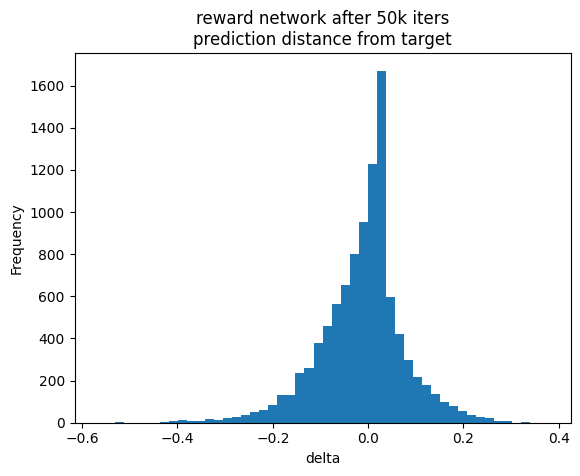

In [81]:
(tmp[0]-tmp[1]).plot.hist(bins=50)
plt.title("reward network after 50k iters\nprediction distance from target")
plt.xlabel("delta")

<Axes: >

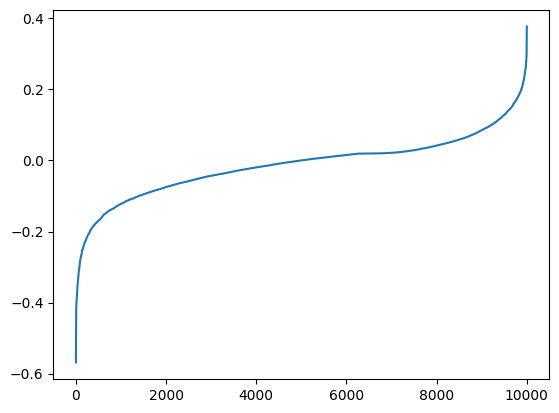

In [62]:
(tmp[0]-tmp[1]).sort_values().reset_index(drop=True).plot()

# MolGAN reward network QQ-plot

> THIS IMAGE IS OUTDATED. the RGCN code has been updated to fix some mistakes

![](reward_net_img1.png)

![alt "WGAN loss function"](WGANL.png "WGAN loss function")

note: GP-term is not used for critic $D$ loss even though $\hat{x}=\epsilon x + (1-\epsilon) G(z)$

In [ ]:
# =================================================================================== #
#                             2. Train the discriminator                              #
# =================================================================================== #

# Compute losses with real inputs.
logits_real, _ = self.D(a_tensor, None, x_tensor) # D(x)

# Z-to-target
edges_logits, nodes_logits = self.G(z) #G(z)
# Postprocess with Gumbel softmax
(edges_hat, nodes_hat) = self.postprocess((edges_logits, nodes_logits), self.post_method)
logits_fake, _ = self.D(edges_hat, None, nodes_hat)# D(G(z))

# Compute losses for gradient penalty.
eps = torch.rand(logits_real.size(0), 1, 1, 1).to(self.device)
x_int0 = (eps             * a_tensor + (1. - eps)             * edges_hat).requires_grad_(True)
x_int1 = (eps.squeeze(-1) * x_tensor + (1. - eps.squeeze(-1)) * nodes_hat).requires_grad_(True)
grad0, grad1 = self.D(x_int0, None, x_int1)
grad_penalty = self.gradient_penalty(grad0, x_int0) + self.gradient_penalty(grad1, x_int1)

d_loss_real = torch.mean(logits_real)
d_loss_fake = torch.mean(logits_fake)
loss_D = d_loss_fake - d_loss_real + self.la_gp * grad_penalty #WGAN loss

# =================================================================================== #
#                               3. Train the generator                                #
# =================================================================================== #

# Z-to-target
edges_logits, nodes_logits = self.G(z)
# Postprocess with Gumbel softmax
(edges_hat, nodes_hat) = self.postprocess((edges_logits, nodes_logits), self.post_method)
logits_fake, _ = self.D(edges_hat, None, nodes_hat) #D(G(z))

# Value losses
value_logit_real, _ = self.V(a_tensor, None, x_tensor, torch.sigmoid) #R(x)
value_logit_fake, _ = self.V(edges_hat, None, nodes_hat, torch.sigmoid) #R(G(z))

# Real Reward
reward_r = torch.from_numpy(self.reward(mols)).to(self.device) #
reward_f = self.get_reward(nodes_hat, edges_hat, self.post_method) #

# Losses Update
loss_G = -logits_fake
# Original TF loss_V. Here we use absolute values instead of the squared one.
# loss_V = (value_logit_real - reward_r) ** 2 + (value_logit_fake - reward_f) ** 2
loss_V = torch.abs(value_logit_real - reward_r) + torch.abs(value_logit_fake - reward_f)
loss_RL = -value_logit_fake

loss_G = torch.mean(loss_G)
loss_V = torch.mean(loss_V)
loss_RL = torch.mean(loss_RL)

alpha = torch.abs(loss_G.detach() / loss_RL.detach()).detach()
train_step_G = cur_la * loss_G + (1 - cur_la) * alpha * loss_RL

train_step_V = loss_V